# Split Data

In [1]:
import os
from io import BytesIO, StringIO
from pathlib import Path

import boto3
import botocore.exceptions
import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split

In [2]:
PROJ_ROOT = Path.cwd().parent

In [3]:
assert load_dotenv(dotenv_path=PROJ_ROOT.parent / '.env')

## About

Load and split the raw churn data.

## User Inputs

In [4]:
# R2 data bucket details
bucket_name = 'cc-churn-splits'
# # name of raw data key (file) in private R2 bucket
r2_key_raw_data = 'BankChurners.xlsx'

# data loading
dtypes = {
    'CLIENTNUM': 'int32[pyarrow]',
    'Attrition_Flag': 'category',
    'Customer_Age': 'int8[pyarrow]',
    'Gender': 'category',
    'Dependent_count': 'int8[pyarrow]',
    'Education_Level': 'category',
    'Marital_Status': 'category',
    'Income_Category': 'category',
    'Card_Category': 'category',
    'Months_on_book (Length of relationship with bansk[months])': 'int16[pyarrow]',
    'Total_Relationship_Count (How many products with customer) ': 'int16[pyarrow]',
    'Months_Inactive_12_mon (Card not used)': 'int16[pyarrow]',
    'Contacts_Count_12_mon (Number of contacts in 12 months)': 'int16[pyarrow]',
    'Credit_Limit': 'float64[pyarrow]',
    'Total_Revolving_Bal (Balance unpaid at month end)': 'float64[pyarrow]',
    'Avg_Open_To_Buy (Difference between the credit limit and the balance)': 'float64[pyarrow]',
    'Total_Amt_Chng_Q4_Q1(Ratio Q4/Q1)': 'float64[pyarrow]',
    'Total_Trans_Amt ( Total Transactions Value 12 months)': 'float64[pyarrow]',
    'Total_Trans_Ct (Transaction Count 12 months)': 'int16[pyarrow]',
    'Total_Ct_Chng_Q4_Q1 (Change in the transaction amount Q4/Q1)': 'float64[pyarrow]',
    'Avg_Utilization_Ratio (Credit usage/Total Credit available)': 'float64[pyarrow]',
}

# data preprocessing
column_renamer_dict = {
    "months_on_book (length of relationship with bansk[months])": "months_on_book",
    "total_relationship_count (how many products with customer) ": "num_products",
    "months_inactive_12_mon (card not used)": "months_inactive_12_mon",
    "total_revolving_bal (balance unpaid at month end)": "total_revolv_bal",
    "contacts_count_12_mon (number of contacts in 12 months)": "contacts_count_12_mon",
    'avg_open_to_buy (difference between the credit limit and the balance)': 'avg_open_to_buy',
    'total_amt_chng_q4_q1(ratio q4/q1)': 'total_amt_chng_q4_q1',
    "total_trans_amt ( total transactions value 12 months)": "total_trans_amt",
    "total_trans_ct (transaction count 12 months)": "total_trans_ct",
    'total_ct_chng_q4_q1 (change in the transaction amount q4/q1)': 'total_ct_chng_q4_q1',
    "avg_utilization_ratio (credit usage/total credit available)": "avg_utilization_ratio",
    'attrition_flag': 'is_churned',
}
label_mapper = {"Existing Customer": 0, "Attrited Customer": 1}
label = 'is_churned'

# data splits
n_cv_folds = 5
# # R2 bucket directory = size_val_0_145_pct
# size_val = 0.145
# # R2 bucket directory = None
size_val = 0.175

# filenames for data splits
r2_key_train = 'train_data.parquet.gzip'
r2_key_val = 'validation_data.parquet.gzip'
r2_key_test = 'test_data.parquet.gzip'

In [5]:
account_id = os.getenv('ACCOUNT_ID')
access_key_id = os.getenv('ACCESS_KEY_ID')
secret_access_key = os.getenv('SECRET_ACCESS_KEY')

s3_client = boto3.client(
    's3',
    endpoint_url=f'https://{account_id}.r2.cloudflarestorage.com',
    aws_access_key_id=access_key_id,
    aws_secret_access_key=secret_access_key,
    region_name='auto'
)

In [6]:
def pandas_read_xlsx_r2(bucket_name, r2_key, dtypes):
    """Read Excel file from private R2 bucket."""
    s3_object = s3_client.get_object(Bucket=bucket_name, Key=r2_key)
    df = pd.read_excel(
        BytesIO(s3_object['Body'].read()), dtype=dtypes, dtype_backend='pyarrow'
    )
    return df


def export_df_to_r2(df, bucket_name, r2_key):
    """Export DataFrame to file in private R2 bucket, if not present."""
    try:
        s3_client.head_object(Bucket=bucket_name, Key=r2_key)
        print(f"Key {r2_key} already exists in bucket {bucket_name}")
    except botocore.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "404":
            print(f"Key {r2_key} does not exist in bucket {bucket_name}")
            buffer = BytesIO()
            df.to_parquet(
                buffer,
                index=False,
                engine='pyarrow',
                compression='gzip',
            )
            response = s3_client.put_object(
                Bucket=bucket_name, Key=r2_key, Body=buffer.getvalue()
            )
            assert response['ResponseMetadata']['HTTPStatusCode'] == 200
            print(f"Exported {len(df):,} rows to key: {r2_key}")
        elif e.response["Error"]["Code"] == "403":
            print(f"Access denied to bucket {bucket_name} or key {r2_key}")
        else:
            print(f"An unexpected error occurred: {e}")

## Extract

In [7]:
%%time
df = pandas_read_xlsx_r2(bucket_name, r2_key_raw_data, dtypes)
print(f"Loaded {len(df):,} rows of raw data")
with pd.option_context('display.max_columns', None):
    display(df)
df.info(memory_usage='deep')

Loaded 10,127 rows of raw data


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book (Length of relationship with bansk[months]),Total_Relationship_Count (How many products with customer),Months_Inactive_12_mon (Card not used),Contacts_Count_12_mon (Number of contacts in 12 months),Credit_Limit,Total_Revolving_Bal (Balance unpaid at month end),Avg_Open_To_Buy (Difference between the credit limit and the balance),Total_Amt_Chng_Q4_Q1(Ratio Q4/Q1),Total_Trans_Amt ( Total Transactions Value 12 months),Total_Trans_Ct (Transaction Count 12 months),Total_Ct_Chng_Q4_Q1 (Change in the transaction amount Q4/Q1),Avg_Utilization_Ratio (Credit usage/Total Credit available)
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777.0,11914.0,1.335,1144.0,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864.0,7392.0,1.541,1291.0,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0.0,3418.0,2.594,1887.0,20,2.333,0.0
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517.0,796.0,1.405,1171.0,20,2.333,0.76
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0.0,4716.0,2.175,816.0,28,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851.0,2152.0,0.703,15476.0,117,0.857,0.462
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186.0,2091.0,0.804,8764.0,69,0.683,0.511
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0.0,5409.0,0.819,10291.0,60,0.818,0.0
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,3,3,5281.0,0.0,5281.0,0.535,8395.0,62,0.722,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                                                                 Non-Null Count  Dtype          
---  ------                                                                 --------------  -----          
 0   CLIENTNUM                                                              10127 non-null  int32[pyarrow] 
 1   Attrition_Flag                                                         10127 non-null  category       
 2   Customer_Age                                                           10127 non-null  int8[pyarrow]  
 3   Gender                                                                 10127 non-null  category       
 4   Dependent_count                                                        10127 non-null  int8[pyarrow]  
 5   Education_Level                                                        10127 non-null  category       
 6   Marital_Status        

## Transform

Perform the following basic data cleaning operations

1. change all column names to lowercase
2. drop duplicates across all columns
   - Duplicate records can skew analysis and model training by giving more weight to repeated entries, which biases the model. This step ensures that each customer contributes equally to the learning process by dropping rows where a client's attributes have been duplicated
3. drop duplicates across the client ID column (`clientnum`)
   - drops rows where a client's ID has been duplicated, to ensure there were no repeated entries for the same customer
4. change label column from string to integer

In [8]:
%%time
df = (
    df
    .rename(columns=str.lower)
    .drop_duplicates(subset=None)
    .drop_duplicates(subset=['clientnum'])
    .rename(columns=column_renamer_dict)
    .assign(
        is_churned=lambda df: (
            df['is_churned'].map(label_mapper).astype('int8[pyarrow]')
        )
    )
)
with pd.option_context('display.max_columns', None):
    display(df)
df.info(memory_usage='deep')

,clientnum,is_churned,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,num_products,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolv_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
0,768805383,0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777.0,11914.0,1.335,1144.0,42,1.625,0.061
1,818770008,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864.0,7392.0,1.541,1291.0,33,3.714,0.105
2,713982108,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0.0,3418.0,2.594,1887.0,20,2.333,0.0
3,769911858,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517.0,796.0,1.405,1171.0,20,2.333,0.76
4,709106358,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0.0,4716.0,2.175,816.0,28,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,0,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851.0,2152.0,0.703,15476.0,117,0.857,0.462
10123,710638233,1,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186.0,2091.0,0.804,8764.0,69,0.683,0.511
10124,716506083,1,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0.0,5409.0,0.819,10291.0,60,0.818,0.0
10125,717406983,1,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,3,3,5281.0,0.0,5281.0,0.535,8395.0,62,0.722,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   clientnum               10127 non-null  int32[pyarrow] 
 1   is_churned              10127 non-null  int8[pyarrow]  
 2   customer_age            10127 non-null  int8[pyarrow]  
 3   gender                  10127 non-null  category       
 4   dependent_count         10127 non-null  int8[pyarrow]  
 5   education_level         10127 non-null  category       
 6   marital_status          10127 non-null  category       
 7   income_category         10127 non-null  category       
 8   card_category           10127 non-null  category       
 9   months_on_book          10127 non-null  int16[pyarrow] 
 10  num_products            10127 non-null  int16[pyarrow] 
 11  months_inactive_12_mon  10127 non-null  int16[pyarrow] 
 12  contacts_count_12_mon   10127 no

**Notes**

1. Created a new binary column named Churn based on the existing Attrition_Flag column. This converts the text labels:
   - "Existing Customer" -> 0 (not churned)
   - "Attrited Customer" -> 1 (churned)

   This is essential because machine learning models require numerical values to perform classification tasks. Once this conversion is done, the original Attrition_Flag column is no longer needed and is dropped.

Create the following data splits

1. training
   - will be used to determine the best ML model, including
     - [decision threshold tuning using cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TunedThresholdClassifierCV.html#tunedthresholdclassifiercv)
     - hyperparameter tuning, with best decision threshold, using cross-validation
2. validation
   - will be used to determine best customer segmantation using business metrics
3. test
   - will be used to evaluate
     - performance of best ML model using ML metrics
     - business metrics to be expected in production

In [9]:
%%time
# get train and test split
df_train, df_test = train_test_split(
    df,
    test_size=size_val/(1-size_val),
    random_state=88,
    shuffle=True,
    stratify=df[label],
)

# get validation split
df_train, df_val = train_test_split(
    df_train,
    test_size=size_val/(1-size_val),
    random_state=88,
    shuffle=True,
    stratify=df_train[label],
)

# show number of observations in each split
n_rows_total = len(df_train) + len(df_val) + len(df_test)
n_rows_cv = int(len(df_train)/n_cv_folds)
frac_rows_cv = 100*n_rows_cv/(len(df_train)+n_rows_cv)
frac_rows_val = 100*len(df_val)/(len(df_train)+len(df_val))
frac_rows_test = 100*len(df_test)/(len(df_train)+len(df_val)+len(df_test))
print(
    f"Training Size: {len(df_train):,}\n"
    f"Cross-Validation Fold Size (Estimate): "
    f"{n_rows_cv:,} ({frac_rows_cv:.2f}%)\n"
    f"Validation Size: {len(df_val):,} ({frac_rows_val:.2f}%)\n"
    f"Test Size: {len(df_test):,} ({frac_rows_test:.2f}%)"
)

# verify that all rows from raw data have been used in the data splits
assert len(df) == n_rows_total

Training Size: 6,285
Cross-Validation Fold Size (Estimate): 1,257 (16.67%)
Validation Size: 1,693 (21.22%)
Test Size: 2,149 (21.22%)
CPU times: user 19.7 ms, sys: 10 μs, total: 19.7 ms
Wall time: 19 ms


**Notes**

1. `startify=True` is necessary due to the known class imbalance of the data.
2. Ideally, if `test_size` is fixed across both splits (train+validation and train+test), the sizes of the cross-validation fold, validation split and test split would be identical.

**Observations**

1. The sizes of the cross-validation fold (approximately 1,396) validation split (approximately 1,427) are nearly identical, which is reassuring. Due to the non-rounded size of the raw data, there are approximately 300 (or ~17%) fewer observations in the validation fold than in the test fold. We will assume this 17% difference is acceptable and further fine-tuning of the split sizes will not be performed.
2. It is reassuring that all observations from the raw data have been used in the data splits.

### Train vs Test Churn Balance (Counts)

Get train, validation and test labels

In [10]:
y_train = df_train[label]
y_val = df_val[label]
y_test = df_test[label]

This chart shows the churn class balance in the training, validation and testing sets. Each bar represents one dataset (Train, Validation or Test) and is divided into stacked segments for non-churn (0) and churn (1). By comparing the bar heights, we can confirm that the stratified split preserved the same churn distribution across all sets while differing in absolute counts.

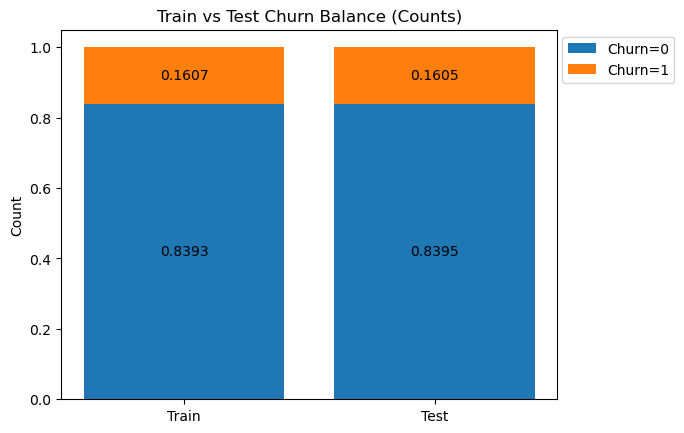

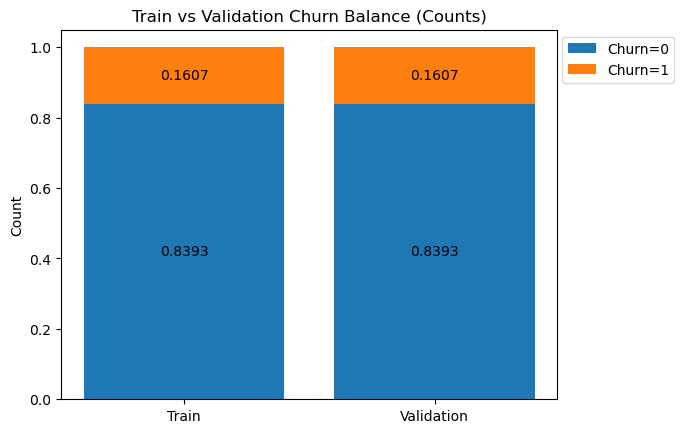

In [11]:
train_counts = y_train.value_counts(normalize=True).sort_index()
val_counts = y_val.value_counts(normalize=True).sort_index()
test_counts  = y_test.value_counts(normalize=True).sort_index()

labels = ["Train","Test"]
churn0_counts = [train_counts.get(0,0), test_counts.get(0,0)]
churn1_counts = [train_counts.get(1,0), test_counts.get(1,0)]

fig, ax = plt.subplots()
ax.bar(labels, churn0_counts, label="Churn=0")
ax.bar(labels, churn1_counts, bottom=churn0_counts, label="Churn=1")
ax.set_ylabel("Count")
ax.set_title("Train vs Test Churn Balance (Counts)")
ax.legend(bbox_to_anchor=(1.25, 1), loc='upper right')

# Annotate values
for i,(c0,c1) in enumerate(zip(churn0_counts, churn1_counts)):
    ax.text(i, c0/2, str(round(c0, 4)), ha="center", va="center")
    ax.text(i, c0+c1/2, str(round(c1, 4)), ha="center", va="center")

plt.show()

labels = ["Train", "Validation"]
churn0_counts = [train_counts.get(0,0), val_counts.get(0,0)]
churn1_counts = [train_counts.get(1,0), val_counts.get(1,0)]

fig, ax = plt.subplots()
ax.bar(labels, churn0_counts, label="Churn=0")
ax.bar(labels, churn1_counts, bottom=churn0_counts, label="Churn=1")
ax.set_ylabel("Count")
ax.set_title("Train vs Validation Churn Balance (Counts)")
ax.legend(bbox_to_anchor=(1.25, 1), loc='upper right')

# Annotate values
for i,(c0,c1) in enumerate(zip(churn0_counts, churn1_counts)):
    ax.text(i, c0/2, str(round(c0, 4)), ha="center", va="center")
    ax.text(i, c0+c1/2, str(round(c1, 4)), ha="center", va="center")

plt.show()

## Load

### Export Project Deliverables to Private R2 Bucket

Export training data split to `train_data.parquet.gzip`

In [12]:
%%time
export_df_to_r2(df_train, bucket_name, r2_key_train)

Key train_data.parquet.gzip does not exist in bucket cc-churn-splits
Exported 6,285 rows to key: train_data.parquet.gzip
CPU times: user 71 ms, sys: 6.99 ms, total: 78 ms
Wall time: 333 ms


Export validation data split to `validation_data.parquet.gzip`

In [13]:
%%time
export_df_to_r2(df_val, bucket_name, r2_key_val)

Key validation_data.parquet.gzip does not exist in bucket cc-churn-splits
Exported 1,693 rows to key: validation_data.parquet.gzip
CPU times: user 20.7 ms, sys: 2.03 ms, total: 22.7 ms
Wall time: 283 ms


Export test data split to `test_data.parquet.gzip`

In [14]:
%%time
export_df_to_r2(df_test, bucket_name, r2_key_test)

Key test_data.parquet.gzip does not exist in bucket cc-churn-splits
Exported 2,149 rows to key: test_data.parquet.gzip
CPU times: user 43.7 ms, sys: 5.98 ms, total: 49.6 ms
Wall time: 315 ms
